### WiSe 2021 Scientific Computing for Economists, Bonn University, Prof. P. Eisenhauer   
### Student: Madina Japakhova
### March, 31 2021   

This project is a practical implementation of the *Kalman filter* discussed in chapter *SEIR Models* in *Applied Mathematics for the Analysis of Biomedical data. Models,methods and MATLAB*. Both the book and the project assume just a layman level of competency in biology, but rather focus on epidemiology and mathematical modelling. Here we look at the use of the Kalman filter in the domain of modelling of infectious diseases (following the book, we model HIV transmission), however the Kalman filter is a powerful tool widely used in a variety of other disciplines. I generally follow the chapter structure, though present alternative estimation methods that were discussed in class. 

# SEIR Models 
    Susceptible - Exposed - Infected - Removed/Recovered models.

## Introduction to the basics of SEIR models

For simplicity, assume we are given a population that happens to be a *closed system*, i.e. no new members are introduced or removed via birth/death or migration. Each member of the population at every time point belongs to one of these four groups:     

   **$S(t)$**: population susceptible to the infection    
   **$E(t)$**: population that was exposed to the infection. Some proceed to become infected, others remain in the exposed group   
   **$I(t)$**: infectious population, i.e. people that are vectors of transmission *unless* measures are taken    
   **$R(t)$**: recovered or removed population, depending on context. In a closed system, people recover.

Members of the susceptible group **$S(t)$** become part of the exposed population $E(t)$ at a rate proportional to $a$<sub>1</sub>, part of the exposed population becomes infected $I(t)$ at a rate proportional to $a$<sub>2</sub>, infected population recovers to $R(t)$ at a rate proportional to $a$<sub>3</sub>, people who recover return to the susceptibles at a rate proportional to $a$<sub>4</sub>. Below is the generic SEIR schema: 

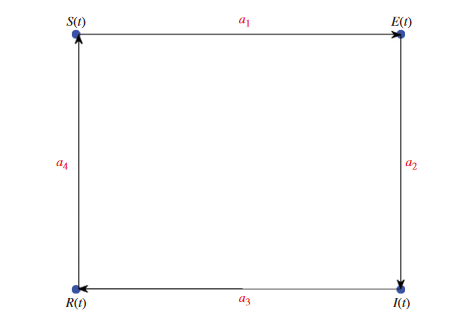

In [124]:
from IPython.display import Image #need to figure out how to draw this diagram by myself.
Image(filename='generic SEIR schema.png')

Translating the qualitative and schematic description of the model into some math, we get a system of four differential equations that tell us how each of the four groups ($S(t)$, $E(t)$, $I(t)$, $R(t)$) changes with time:  

$$ 
\frac{dS}{dt} = -a_{1}S(t) + a_{4}R(t)
$$

$$
\frac{dE}{dt}= a_{1}S(t) - a_{2}E(t)  
$$

$$
\frac{dI}{dt} = a_{2}E(t) + a_{3}I(t)   
$$

$$
\frac{dR}{dt} = a_{3}I(t) + a_{4}R(t)  
$$ 

To exercise the model, we need estimates of the parameters $a_{1}$, $a_{2}$, $a_{3}$, $a_{4}$ together with data on the *initial population* $S_{0} = S(t_{0})$, $E_{0}, I_{0}$. ***The Kalman filter*** combines the time series data and mathematical model to produce an optimal estimate of the model "*state*" along with a probabilistic error.

## Practical applications of SEIR models 
### Transmission of HIV and seroconversion to AIDS   

### Setting   

We are no longer in a closed system. New members are intoduced(removed) from the population via births(deaths) and migration.

$S(t)$: population susceptible to the transmission of HIV at time $t$     

$X(t)$: HIV positive ($HIV^{+}$) population    

$X_{q}$: $HIV^{+}$, but no longer infectious at time $t$     

$Y(t)$: AIDS population     

$Y_{q}$: AIDS, but no longer infectious at time $t$    

$B$: number of new susceptibles introduced into the population per time unit   

$\mu_{D}$: rate at which people are removed from the population due to "non-AIDS" causes    

$\mu_{A}$: rate at which people die from AIDS    

$p$: proportion of the infectious population who are not "quarantined"    

$I(t) = X(t) + Y(t)$: total infectious population at time $t$   

$N(t( = S(t) + I(t)$: total active at risk population at time $t$     

$\lambda$$(t)$  $=$ $\beta$$(t)$$\frac{I(t)}{N(t)}$: the probability of HIV transmission per contact at time $t$    

$c(t)$: number of contacts(partners) at time $t$    

$v(t)$: seroconversion rate from HIV to AIDS; $\frac{1}{v(t)}$ $=$ incubation period   

$Births$: the number of people entering the susceptible population (births, immigration)   

$D_{n}$: number of people leaving the susceptible population (non-AIDS deaths, emigration)   

$D_{a}$: number of deaths due to AIDS


$$ 
\frac{dS}{dt} = B - \lambda c(t)S(t) - \mu_{D} S(t)
$$

$$
\frac{dX}{dt}= \lambda c(t)S(t) - (\mu_{D} + (1-p)+p v(t))X(t)
$$

$$
\frac{dX_{q}}{dt} = (1-p)X(t) - (\mu_{D} + v(t))X_{q}
$$

$$
\frac{dY}{dt} = p v(t)X(t) - (\mu_{A} + (1-p) + \mu_{D})Y(t)
$$ 

$$
\frac{dY_{q}}{dt} = (1-p)Y(t) - (\mu_{D} + \mu_{A})Y_{q}(t) + v(t)X_{q}
$$ 

Goal: estimate parameters 

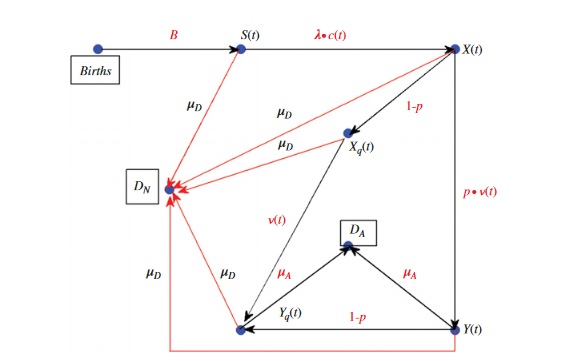

In [125]:
Image(filename='SEIR schema of HIV transmission and AIDS seroconversion.png')

In [107]:
import pandas as pd 
import numpy as np
import scipy
from scipy.optimize import curve_fit
import math

### Estimating $\beta$$(t)$ -  the probability of HIV transmission at time $t$

The transmission parameter $\beta$ is pretty much dependent on the type of interaction between the carrier of HIV and the exposed individual. In sex, the probability of transmission from a man to a woman $\beta_{MF}$ is $0.001$, while from a woman to a man $\beta_{FM}$ $-$ 0.000025, the highest probability of transmission is in a male-to-male interaction, $\beta_{MM}$ $= 0.1$. Therefore, estimated $\beta$ is highly dependent on the demographics of a given population. Peterson provided data on the transmission probabilities as a function of ***contact*** (with the $HIV^{+}$) and ***time***(days). This data will be used in our model for the probability of transmission.

In [127]:
hiv_betas = pd.read_csv("peterson hiv probabilities.csv")
hiv_betas['time_years'] = hiv_betas['time']/365.25
hiv_betas.head(10)

,beta_hat_t,time,time_years
0,0.630,40,0.109514
1,0.580,60,0.164271
2,0.500,80,0.219028
3,0.430,100,0.273785
4,0.360,120,0.328542
5,0.300,140,0.383299
6,0.275,160,0.438056
7,0.260,180,0.492813
8,0.240,200,0.547570
9,0.230,220,0.602327


Transmission probability as a function of contact and time(years) is an exponential:    

$$
\beta(t,c) = c_{1}e^{-c_{2}(t-t_{1})} + c_{3}
$$

In the chapter, author estimated $c = (c_{1}, c_{2}, c_{3})$ for $t_{1}$ $= 40$ days or $0.1095$ year in MATLAB with a non-linear regression fit. His estimates for $c = (0.5745, 2.9466, 0.0708)$. I will also show regression fit estimates, but also an alternative approach by minimizing the loss function with a gradient descent.   

Estimating **c** with a non-linear regression fit yields estimates similar to the author's:

In [131]:
def model(t, c1, c2, c3): 
    "t1 = 0.1095"
    return c1*np.exp(-c2*(t-0.1095)) + c3  
popt, pcov = curve_fit(model, t, betas_hat) 
print(f"Estimated c1, c2 and c3 are {popt}")

Estimated c1, c2 and c3 are [0.57562405 2.93620495 0.06963139]


An alternative way to approach estimating $c$ is to find where the cost function $E(c)$ is minimized.   

$$ 
E(c) = \sum\limits_{j-1}^{N}(c_{1}e^{-c_{2}(t-t_{1})} + c_{3} - \hat{\beta}(t_{j})^{2}
$$ 

Estimating where the cost function is minimized with a gradient descent

In [138]:
#partial derivatives w.r.t c1,c2 and c3
def grad(t,betas_hat, c1,c2,c3):  
        dc1 = 2*np.sum((c1*np.exp(-c2*(t-t[0])) + c3 - betas_hat)* np.exp(-c2*(t-t[0])))
        dc2 = 2*np.sum((c1*np.exp(-c2*(t-t[0])) + c3 - betas_hat) *c1*np.exp(-c2*(t-t[0])) * (t[0]-t))
        dc3 = 2*np.sum((c1*np.exp(-c2*(t-t[0])) + c3 - betas_hat))
        return np.array([dc1,dc2,dc3])

#parameters
learning_rate= 0.01
precision = 0.0001
previous_step_size = 1 
max_iters = 100000
iters = 0 

#initial arbitrarily chosen starting point
C = np.array([1,1,1])

#Inputs of the cost function
betas_hat = hiv_betas['beta_hat_t'].values
t = hiv_betas['time_years'].values

while previous_step_size > precision and iters < max_iters: 
    C_prev = C
    C = C-learning_rate*grad(t, betas_hat, C[0], C[1], C[2])
    previous_step_size = abs((C-C_prev).any())
    iters = iters+1   
    
print(f"E[c] is at its minimum when c1, c2 and c3 are {C}") 

E[c] is at its minimum when c1, c2 and c3 are [0.57560033 2.93620494 0.06963139]


As shown, the gradient descent arrived at values very almost identical to those of a regression fit. Though, my gradient descent is sensitive to number of iterations and takes more computational time.

In [150]:
def error(t, betas_hat):
    n = t.size 
    C_est  = np.tile(C, (1,n)) 
    C_est = C
    c1_est = C_est[0]
    c2_est = C_est[1]
    c3_est = C_est[2] 
    loss = np.sum((c1_est*np.exp(-c2_est*(t-t[0])) + c3_est - betas_hat)**2)
    error = np.sqrt((loss)/n)
    return error 

print(f"Root mean square error is {error(t, betas_hat)}")

Root mean square error is 0.014622223972518703


Our estimated mean square error is close, but slightly smaller than the one obtained in the book: $0.0151$.

Plotting $\beta$ at estimated **c**

<AxesSubplot:title={'center':'Peterson data'}, xlabel='time, years', ylabel='HIV transmission'>

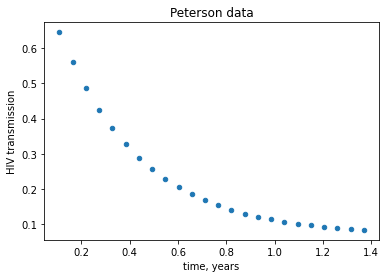

In [139]:
a = model(t,0.57562405, 2.93620494, 0.06963139)
betas = pd.DataFrame({'x':t, 'y':a})
betas.plot('x', 'y', kind='scatter', xlabel = 'time, years', ylabel = 'HIV transmission', title = 'Peterson data')